# MLP
MLP, K=5, epochs=200.
Use mRNA.
Train set: filter none.
Valid set: filter middle.

In [13]:
from datetime import datetime
print(datetime.now())

2023-04-01 23:09:10.637619


In [14]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [15]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=200 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = True
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = True

Python 3.9.16
sklearn 1.2.2


In [16]:
RCI_FILE_TRAIN = 'train.pc_RCI.csv'
RCI_FILE_VALID = 'train.pc_RCI.csv'
RCI_FILE_TEST  = None # else 'test.pc_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_pc_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_pc_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_pc_transcripts.csv'

In [17]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [18]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [19]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    layer3 = Dense(64, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(layer3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return mlp

In [20]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-01 23:09:11.768263
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 64)                65664     
                                                                 
 dense_45 (Dense)            (None, 64)                4160      
                                                                 
 dense_46 (Dense)            (None, 64)                4160      
                                                                 
 dense_47 (Dense)            (None, 1)                 65        
                                                                 
Total params: 74,049
Trainable params: 74,049
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [21]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
            self.discriminator = 0   # more balanced for mRNA
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            self.model.save(filename)
        
    def load_model(self,filename):
        self.model = keras.models.load_model(filename)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [22]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        # lncRNA
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        # mRNA
        filename='pc.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if not FILTER_TEST or \
                    (FILTER_TAILS_TEST and in_middle) or \
                    (FILTER_MIDDLE_TEST and in_tails):
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if not FILTER_TRAIN or \
                    (FILTER_TAILS_TRAIN and in_middle) or \
                    (FILTER_MIDDLE_TRAIN and in_tails):
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-01 23:09:11.972140
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.pc_RCI.csv
Number of RCI values loaded 13669
Num RCI: 13669
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_pc_transcripts.csv
Loaded 13669 sequences.
2023-04-01 23:10:19.221873

Training # 1 1
2023-04-01 23:10:19.222130
2023-04-01 23:10:19.222211
Discriminator ZERO 0
Train 1:0 5722:5211 52.34%
Computed class weights: {0: 1.0490308961811552, 1: 0.95534778049633}
Valid 1:0 1417:217 86.72%
FIT
2023-04-01 23:10:19.353756


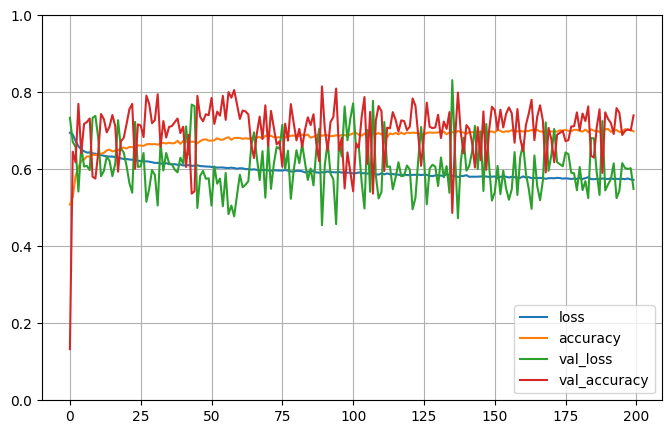


2023-04-01 23:14:22.626712

Testing # 1 1
2023-04-01 23:14:22.626834
2023-04-01 23:14:22.626879
PREDICT
2023-04-01 23:14:22.645132
Test 1:0 1417:217 86.72%
Predict 1:0 1138:496 69.65%
Test sizes (1634, 1025) (1634,)
Range of scores: 0.02356992 to 0.9713678
Score threshold 0.5
Confusion matrix
 [[ 144   73]
 [ 352 1065]]
Normalized matrix
 [[0.08812729 0.04467564]
 [0.21542228 0.65177479]]


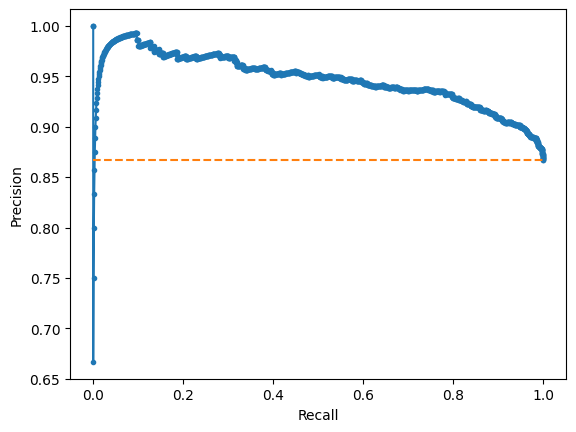

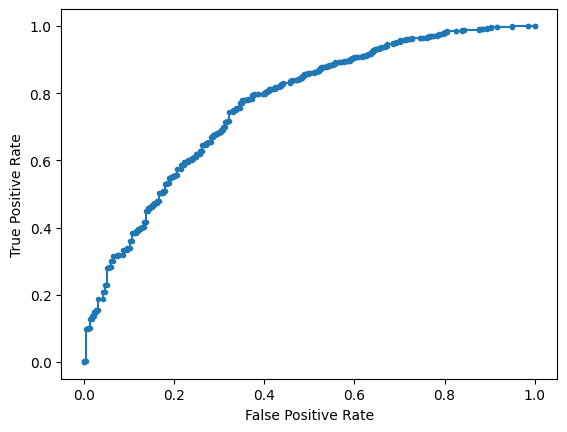

Accuracy: 73.99% Precision: 93.59% Recall: 75.16%
F1: 83.37% MCC: 0.3064
AUPRC: 94.69% AUROC: 76.58%
 accuracy [73.99020807833537]
 precision [93.58523725834797]
 recall [75.15878616796047]
 F1 [83.36594911937377]
 MCC [0.30643734181626037]
 AUPRC [94.68594009868163]
 AUROC [76.58485344191173]
2023-04-01 23:14:23.364389

Training # 1 2
2023-04-01 23:14:23.365209
2023-04-01 23:14:23.365272
Discriminator ZERO 0
Train 1:0 5688:5244 52.03%
Computed class weights: {0: 1.0423340961098397, 1: 0.9609704641350211}
Valid 1:0 1451:217 86.99%
FIT
2023-04-01 23:14:23.501921


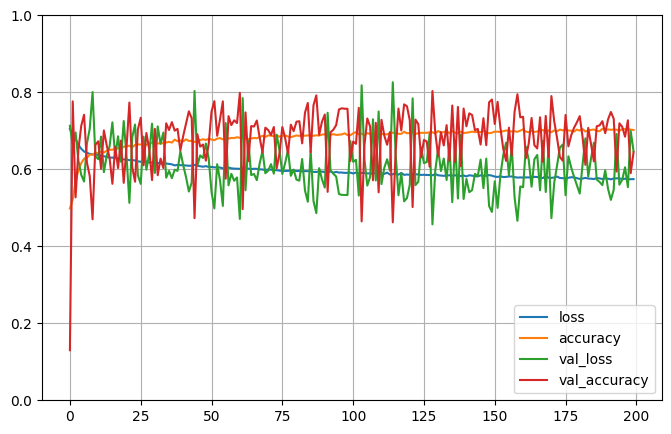


2023-04-01 23:18:26.259587

Testing # 1 2
2023-04-01 23:18:26.259698
2023-04-01 23:18:26.259743
PREDICT
2023-04-01 23:18:26.280370
Test 1:0 1451:217 86.99%
Predict 1:0 981:687 58.81%
Test sizes (1668, 1025) (1668,)
Range of scores: 0.046564322 to 0.9788087
Score threshold 0.5
Confusion matrix
 [[155  62]
 [532 919]]
Normalized matrix
 [[0.09292566 0.03717026]
 [0.31894484 0.55095923]]


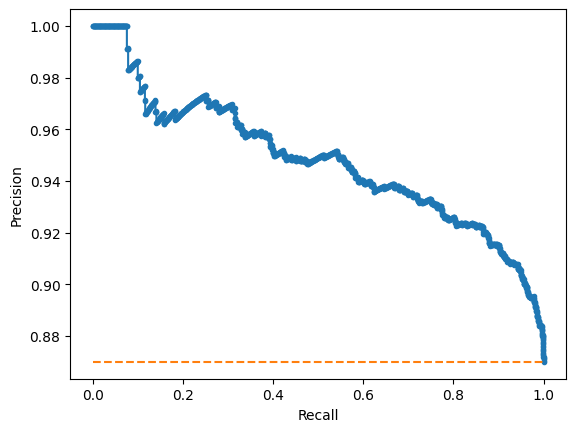

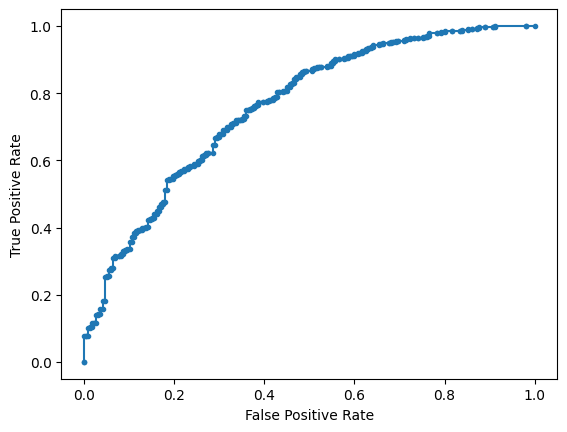

Accuracy: 64.39% Precision: 93.68% Recall: 63.34%
F1: 75.58% MCC: 0.2376
AUPRC: 94.80% AUROC: 75.90%
 accuracy [64.38848920863309]
 precision [93.67991845056065]
 recall [63.33563059958649]
 F1 [75.57565789473685]
 MCC [0.2376199860420468]
 AUPRC [94.79552089897099]
 AUROC [75.89585444012869]
2023-04-01 23:18:27.029608

Training # 1 3
2023-04-01 23:18:27.030389
2023-04-01 23:18:27.030453
Discriminator ZERO 0
Train 1:0 5711:5234 52.18%
Computed class weights: {0: 1.0455674436377531, 1: 0.9582384871300998}
Valid 1:0 1428:217 86.81%
FIT
2023-04-01 23:18:27.169044


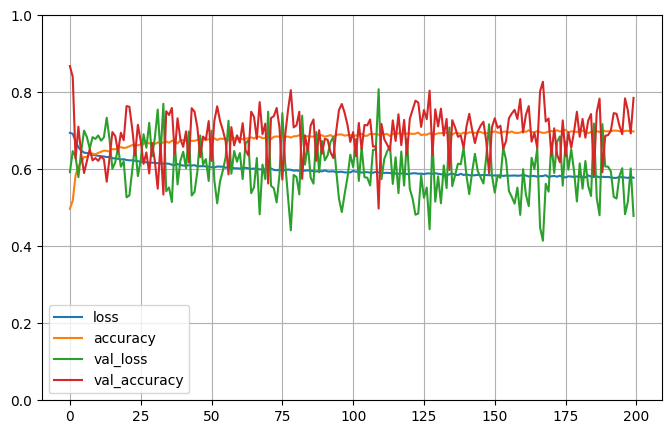


2023-04-01 23:22:50.413734

Testing # 1 3
2023-04-01 23:22:50.413848
2023-04-01 23:22:50.413894
PREDICT
2023-04-01 23:22:50.432664
Test 1:0 1428:217 86.81%
Predict 1:0 1279:366 77.75%
Test sizes (1645, 1025) (1645,)
Range of scores: 0.049318045 to 0.9896185
Score threshold 0.5
Confusion matrix
 [[ 115  102]
 [ 251 1177]]
Normalized matrix
 [[0.06990881 0.06200608]
 [0.15258359 0.71550152]]


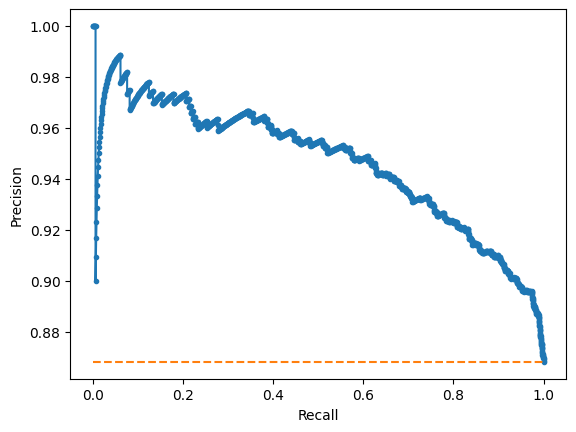

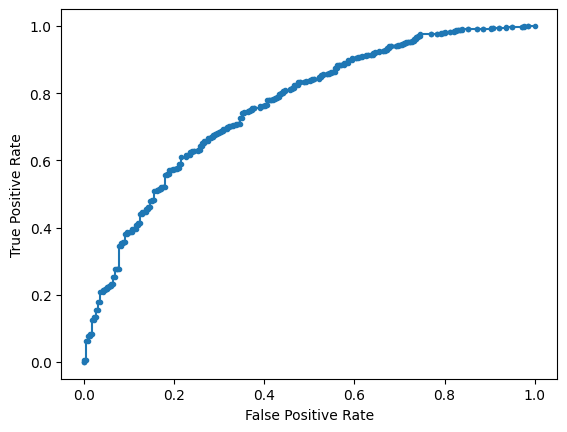

Accuracy: 78.54% Precision: 92.03% Recall: 82.42%
F1: 86.96% MCC: 0.2882
AUPRC: 94.63% AUROC: 76.00%
 accuracy [78.54103343465046]
 precision [92.02501954652071]
 recall [82.42296918767506]
 F1 [86.95973402290358]
 MCC [0.288168572097984]
 AUPRC [94.63422295300224]
 AUROC [75.99555951412823]
2023-04-01 23:22:51.172702

Training # 1 4
2023-04-01 23:22:51.173380
2023-04-01 23:22:51.173442
Discriminator ZERO 0
Train 1:0 5701:5226 52.17%
Computed class weights: {0: 1.0454458476846538, 1: 0.9583406419926329}
Valid 1:0 1438:226 86.42%
FIT
2023-04-01 23:22:51.305978


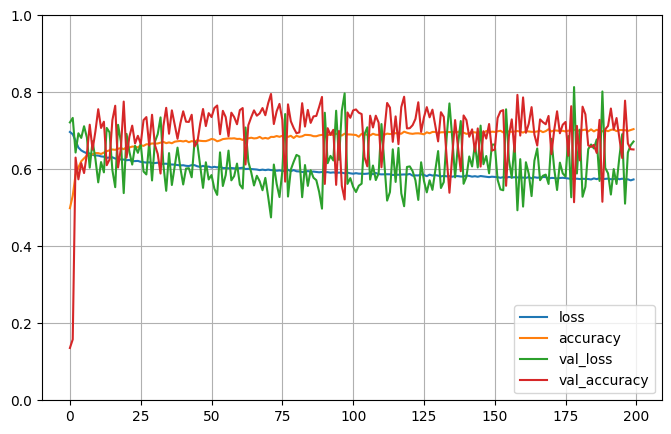


2023-04-01 23:26:55.889480

Testing # 1 4
2023-04-01 23:26:55.889585
2023-04-01 23:26:55.889637
PREDICT
2023-04-01 23:26:55.906853
Test 1:0 1438:226 86.42%
Predict 1:0 984:680 59.13%
Test sizes (1664, 1025) (1664,)
Range of scores: 0.016897446 to 0.95590734
Score threshold 0.5
Confusion matrix
 [[163  63]
 [517 921]]
Normalized matrix
 [[0.09795673 0.03786058]
 [0.31069712 0.55348558]]


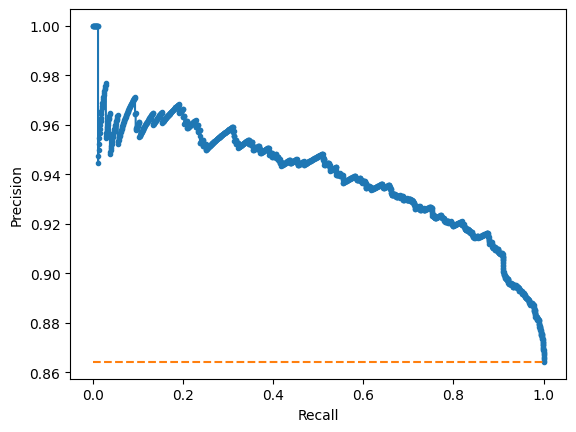

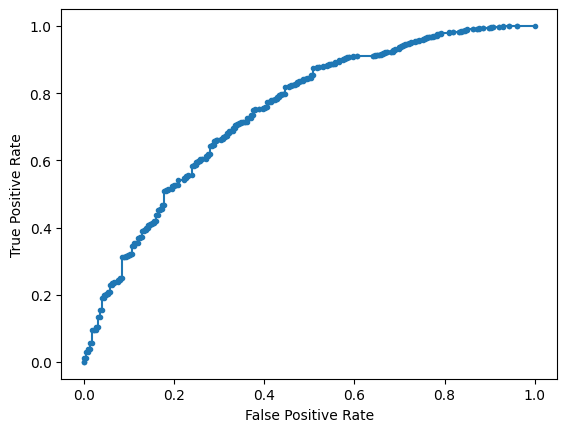

Accuracy: 65.14% Precision: 93.60% Recall: 64.05%
F1: 76.05% MCC: 0.2521
AUPRC: 93.90% AUROC: 74.60%
 accuracy [65.14423076923077]
 precision [93.59756097560977]
 recall [64.04728789986092]
 F1 [76.05284888521882]
 MCC [0.25208346183975544]
 AUPRC [93.89602646304161]
 AUROC [74.60090834123106]
2023-04-01 23:26:56.601308

Training # 1 5
2023-04-01 23:26:56.601571
2023-04-01 23:26:56.601612
Discriminator ZERO 0
Train 1:0 5734:5205 52.42%
Computed class weights: {0: 1.0508165225744477, 1: 0.9538716428322288}
Valid 1:0 1405:227 86.09%
FIT
2023-04-01 23:26:56.732774


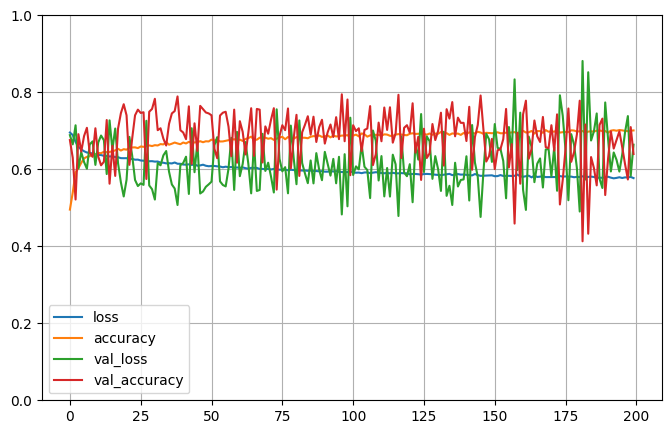


2023-04-01 23:31:08.755932

Testing # 1 5
2023-04-01 23:31:08.756052
2023-04-01 23:31:08.756114
PREDICT
2023-04-01 23:31:08.784278
Test 1:0 1405:227 86.09%
Predict 1:0 945:687 57.90%
Test sizes (1632, 1025) (1632,)
Range of scores: 0.042143933 to 0.97423744
Score threshold 0.5
Confusion matrix
 [[163  64]
 [524 881]]
Normalized matrix
 [[0.09987745 0.03921569]
 [0.32107843 0.53982843]]


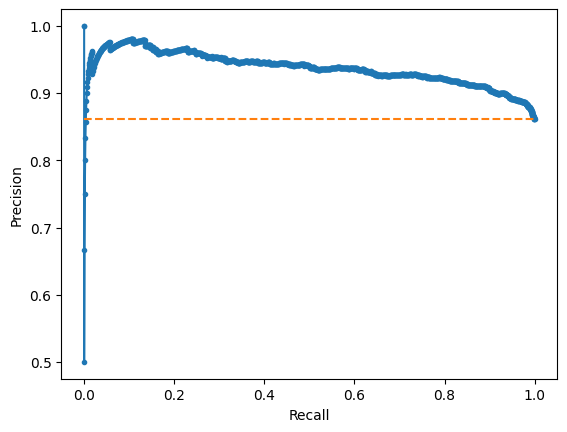

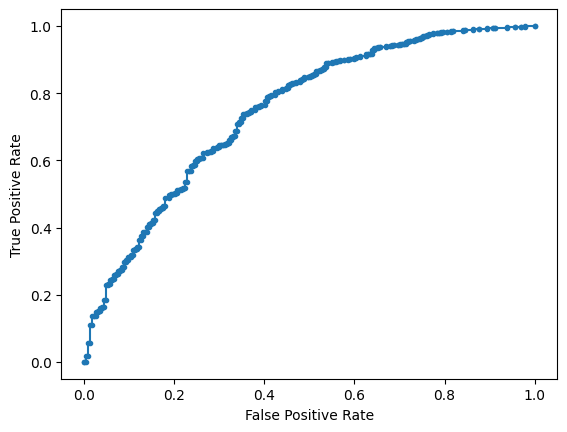

Accuracy: 63.97% Precision: 93.23% Recall: 62.70%
F1: 74.98% MCC: 0.2419
AUPRC: 93.70% AUROC: 74.76%
 accuracy [63.970588235294116]
 precision [93.22751322751323]
 recall [62.704626334519574]
 F1 [74.97872340425532]
 MCC [0.2418865754417709]
 AUPRC [93.70198399450311]
 AUROC [74.75880665339332]
2023-04-01 23:31:09.583053

Training # 2 1
2023-04-01 23:31:09.584197
2023-04-01 23:31:09.584276
Discriminator ZERO 0
Train 1:0 5710:5221 52.24%
Computed class weights: {0: 1.0468301091744876, 1: 0.9571803852889668}
Valid 1:0 1429:221 86.61%
FIT
2023-04-01 23:31:09.769158


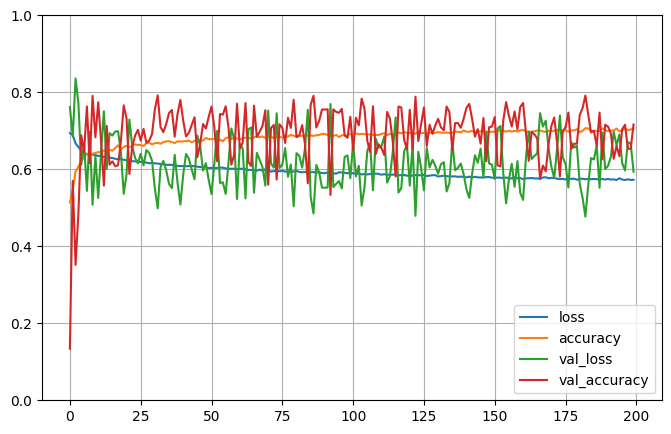


2023-04-01 23:36:33.256184

Testing # 2 1
2023-04-01 23:36:33.256309
2023-04-01 23:36:33.256363
PREDICT
2023-04-01 23:36:33.279793
Test 1:0 1429:221 86.61%
Predict 1:0 1133:517 68.67%
Test sizes (1650, 1025) (1650,)
Range of scores: 0.034993824 to 0.9544755
Score threshold 0.5
Confusion matrix
 [[ 135   86]
 [ 382 1047]]
Normalized matrix
 [[0.08181818 0.05212121]
 [0.23151515 0.63454545]]


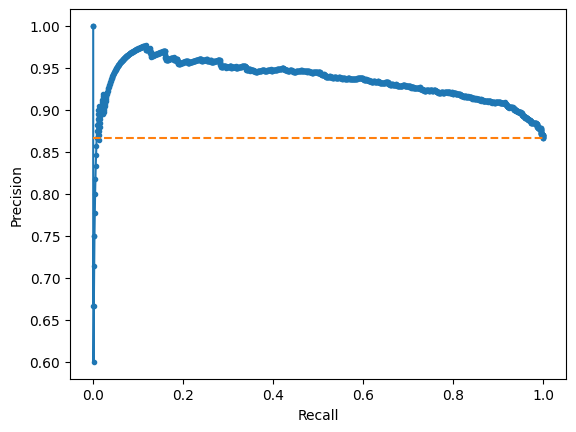

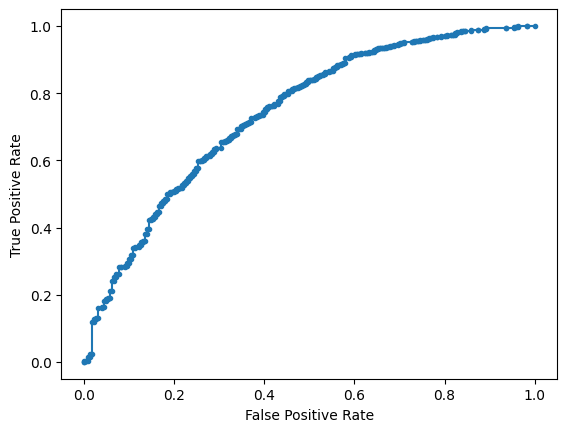

Accuracy: 71.64% Precision: 92.41% Recall: 73.27%
F1: 81.73% MCC: 0.2522
AUPRC: 93.49% AUROC: 73.94%
 accuracy [71.63636363636363]
 precision [92.40953221535746]
 recall [73.26801959412175]
 F1 [81.73302107728337]
 MCC [0.25224887648321054]
 AUPRC [93.49421703339902]
 AUROC [73.94437777264106]
2023-04-01 23:36:34.035640

Training # 2 2
2023-04-01 23:36:34.039067
2023-04-01 23:36:34.039378
Discriminator ZERO 0
Train 1:0 5724:5220 52.30%
Computed class weights: {0: 1.0482758620689656, 1: 0.9559748427672956}
Valid 1:0 1415:205 87.35%
FIT
2023-04-01 23:36:34.222316


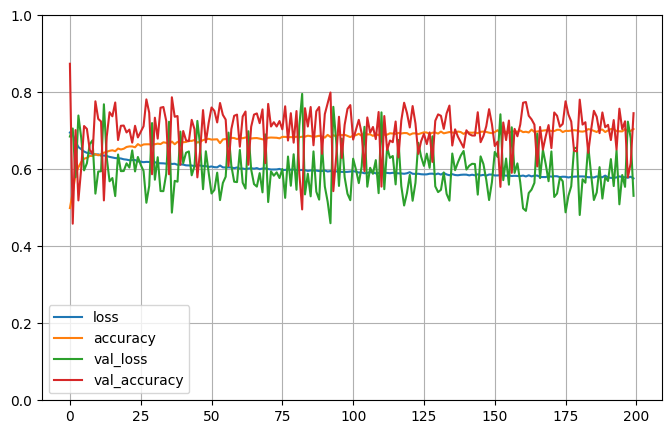


2023-04-01 23:40:57.502007

Testing # 2 2
2023-04-01 23:40:57.502145
2023-04-01 23:40:57.502198
PREDICT
2023-04-01 23:40:57.523572
Test 1:0 1415:205 87.35%
Predict 1:0 1167:453 72.04%
Test sizes (1620, 1025) (1620,)
Range of scores: 0.052454114 to 0.97913074
Score threshold 0.5
Confusion matrix
 [[ 123   82]
 [ 330 1085]]
Normalized matrix
 [[0.07592593 0.05061728]
 [0.2037037  0.66975309]]


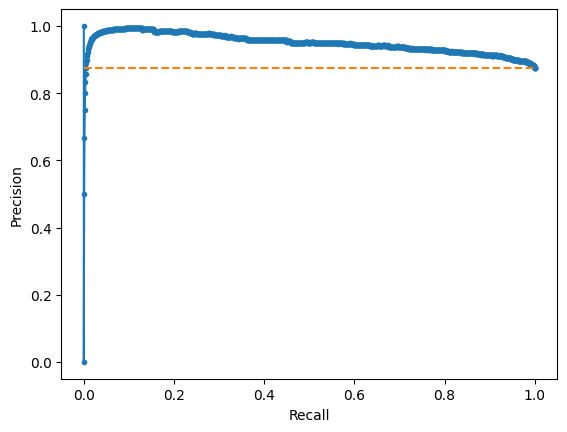

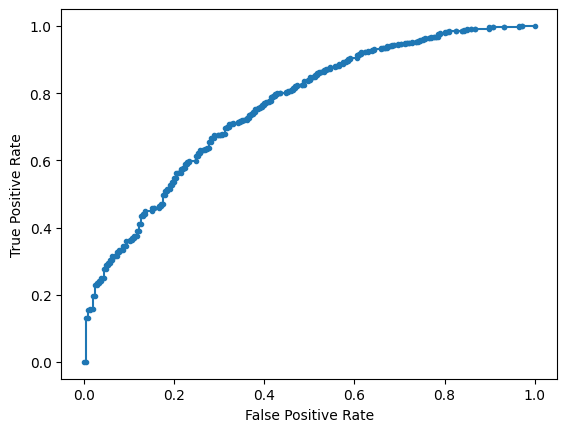

Accuracy: 74.57% Precision: 92.97% Recall: 76.68%
F1: 84.04% MCC: 0.2717
AUPRC: 94.91% AUROC: 75.97%
 accuracy [74.5679012345679]
 precision [92.97343616109683]
 recall [76.67844522968198]
 F1 [84.04337722695587]
 MCC [0.2716949332121542]
 AUPRC [94.91311939847873]
 AUROC [75.97035249504438]
2023-04-01 23:40:58.197446

Training # 2 3
2023-04-01 23:40:58.198290
2023-04-01 23:40:58.198358
Discriminator ZERO 0
Train 1:0 5720:5217 52.30%
Computed class weights: {0: 1.0482077822503355, 1: 0.9560314685314686}
Valid 1:0 1419:203 87.48%
FIT
2023-04-01 23:40:58.333665


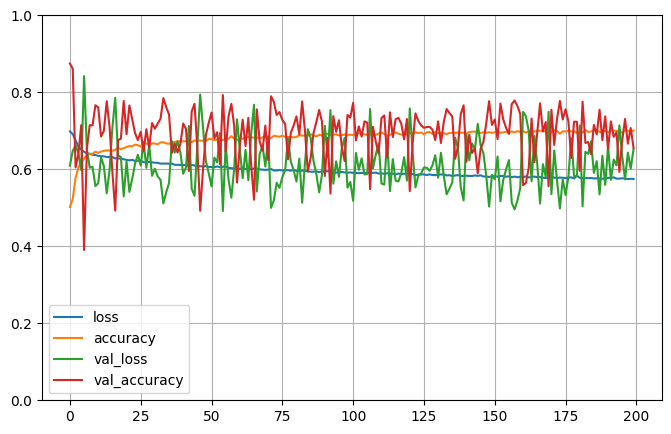


2023-04-01 23:45:01.210768

Testing # 2 3
2023-04-01 23:45:01.210890
2023-04-01 23:45:01.210978
PREDICT
2023-04-01 23:45:01.226919
Test 1:0 1419:203 87.48%
Predict 1:0 981:641 60.48%
Test sizes (1622, 1025) (1622,)
Range of scores: 0.037194718 to 0.9536474
Score threshold 0.5
Confusion matrix
 [[143  60]
 [498 921]]
Normalized matrix
 [[0.08816276 0.03699137]
 [0.30702836 0.56781751]]


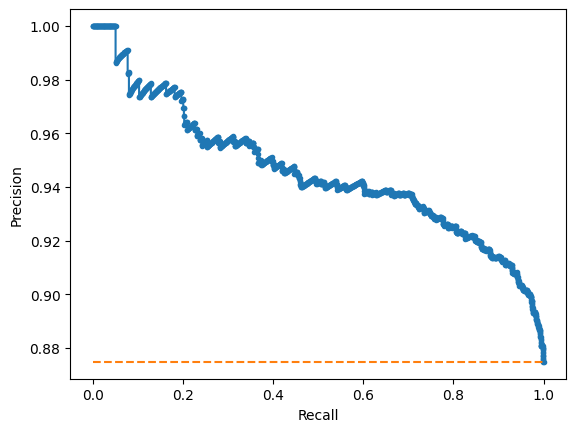

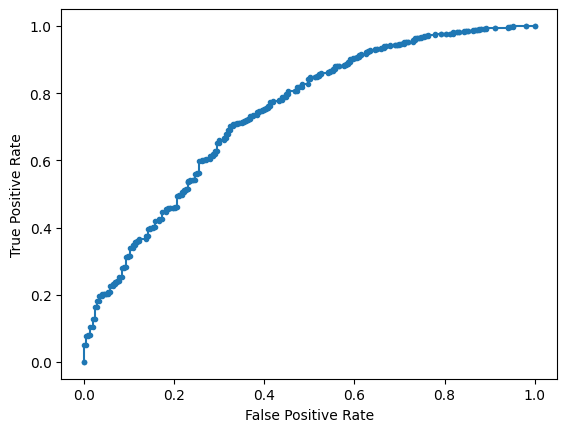

Accuracy: 65.60% Precision: 93.88% Recall: 64.90%
F1: 76.75% MCC: 0.2392
AUPRC: 94.55% AUROC: 74.04%
 accuracy [65.5980271270037]
 precision [93.88379204892966]
 recall [64.90486257928119]
 F1 [76.74999999999999]
 MCC [0.23924515597510237]
 AUPRC [94.55303466869383]
 AUROC [74.0395130130495]
2023-04-01 23:45:02.486794

Training # 2 4
2023-04-01 23:45:02.488301
2023-04-01 23:45:02.488555
Discriminator ZERO 0
Train 1:0 5672:5261 51.88%
Computed class weights: {0: 1.0390610150161566, 1: 0.9637693935119888}
Valid 1:0 1467:237 86.09%
FIT
2023-04-01 23:45:02.624912


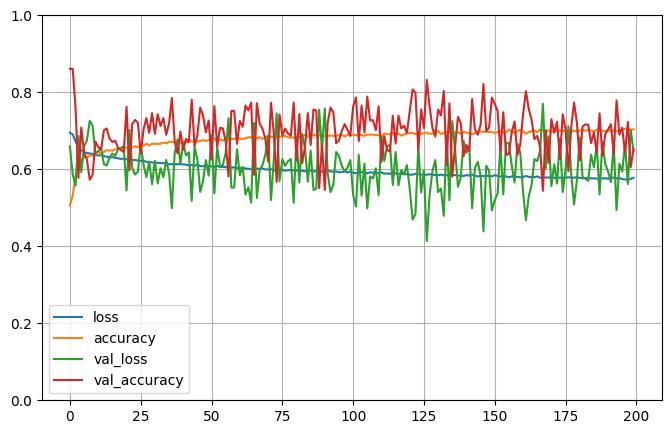


2023-04-01 23:49:26.083591

Testing # 2 4
2023-04-01 23:49:26.086045
2023-04-01 23:49:26.086595
PREDICT
2023-04-01 23:49:26.107205
Test 1:0 1467:237 86.09%
Predict 1:0 987:717 57.92%
Test sizes (1704, 1025) (1704,)
Range of scores: 0.034212895 to 0.95601475
Score threshold 0.5
Confusion matrix
 [[181  56]
 [536 931]]
Normalized matrix
 [[0.10622066 0.03286385]
 [0.31455399 0.5463615 ]]


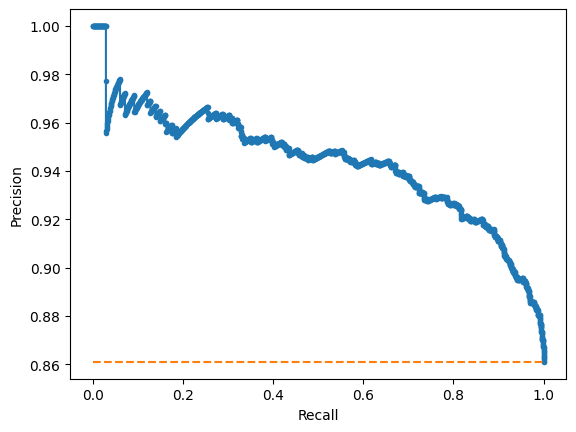

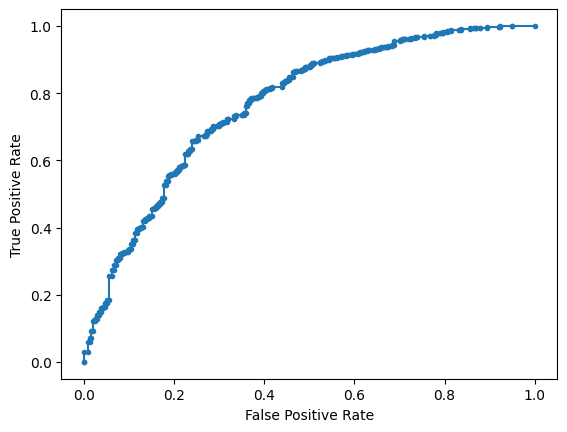

Accuracy: 65.26% Precision: 94.33% Recall: 63.46%
F1: 75.88% MCC: 0.2792
AUPRC: 94.37% AUROC: 76.78%
 accuracy [65.25821596244131]
 precision [94.32624113475178]
 recall [63.4628493524199]
 F1 [75.8761206193969]
 MCC [0.2792072624530841]
 AUPRC [94.36518978049176]
 AUROC [76.78145645839984]
2023-04-01 23:49:26.977803

Training # 2 5
2023-04-01 23:49:26.978062
2023-04-01 23:49:26.978157
Discriminator ZERO 0
Train 1:0 5730:5201 52.42%
Computed class weights: {0: 1.0508556046914055, 1: 0.9538394415357766}
Valid 1:0 1409:238 85.55%
FIT
2023-04-01 23:49:27.111569


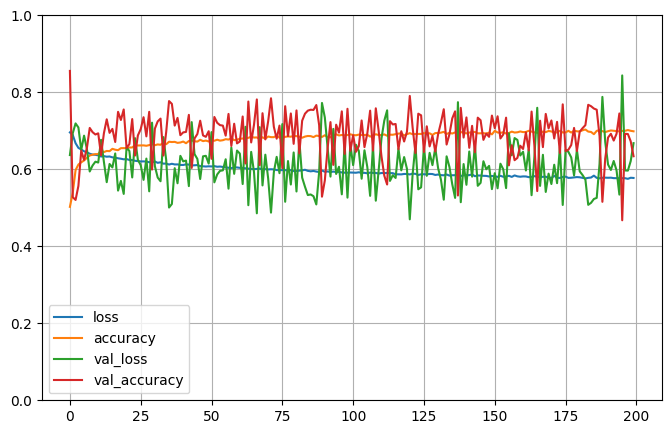


2023-04-01 23:53:50.358939

Testing # 2 5
2023-04-01 23:53:50.359064
2023-04-01 23:53:50.359133
PREDICT
2023-04-01 23:53:50.383736
Test 1:0 1409:238 85.55%
Predict 1:0 918:729 55.74%
Test sizes (1647, 1025) (1647,)
Range of scores: 0.038821273 to 0.97781247
Score threshold 0.5
Confusion matrix
 [[182  56]
 [547 862]]
Normalized matrix
 [[0.11050395 0.03400121]
 [0.332119   0.52337583]]


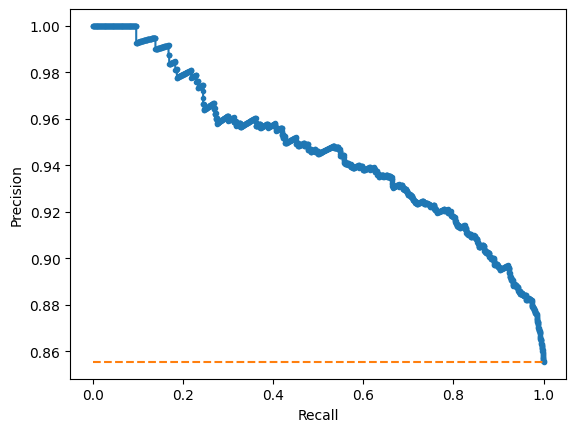

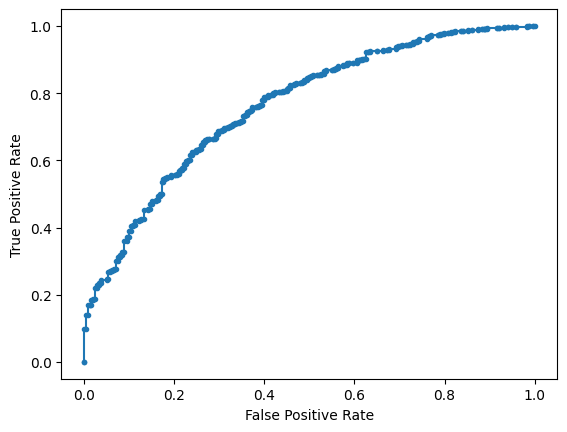

Accuracy: 63.39% Precision: 93.90% Recall: 61.18%
F1: 74.09% MCC: 0.2665
AUPRC: 94.60% AUROC: 76.20%
 accuracy [63.387978142076506]
 precision [93.89978213507625]
 recall [61.17814052519518]
 F1 [74.0868070477009]
 MCC [0.26650734747240495]
 AUPRC [94.59551586747574]
 AUROC [76.2031001186848]
2023-04-01 23:53:51.127634


In [23]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [24]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 68.65% std 5.49
 precision mean 93.36% std 0.71
 recall mean 68.72% std 7.45
 F1 mean 78.94% std 4.60
 MCC mean 0.26% std 0.02
 AUPRC mean 94.36% std 0.49
 AUROC mean 75.48% std 1.05
 accuracy [[73.99020807833537], [64.38848920863309], [78.54103343465046], [65.14423076923077], [63.970588235294116], [71.63636363636363], [74.5679012345679], [65.5980271270037], [65.25821596244131], [63.387978142076506]]
 precision [[93.58523725834797], [93.67991845056065], [92.02501954652071], [93.59756097560977], [93.22751322751323], [92.40953221535746], [92.97343616109683], [93.88379204892966], [94.32624113475178], [93.89978213507625]]
 recall [[75.15878616796047], [63.33563059958649], [82.42296918767506], [64.04728789986092], [62.704626334519574], [73.26801959412175], [76.67844522968198], [64.90486257928119], [63.4628493524199], [61.17814052519518]]
 F1 [[83.36594911937377], [75.57565789473685], [86.95973402290358], [76.05284888521882], [74.97872340425532], [81.73302107728337], [84.04337